In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import glob
import re
from collections import Counter

In [3]:
txt_files = []
for _ in glob.glob("/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge/*/*/*.txt"):
    txt_files.append(_)

In [4]:
len(txt_files)

4405

# Txt Reader

In [5]:
list_txt = []
for _file in txt_files:
    with open(_file) as f:
        list_txt.append(f.read())
        # list_txt.append("".join((f.readlines())))

Total Number of "txt" files:

In [6]:
len(list_txt)

4405

In [7]:
list_txt[:3]

['HABITS: \nTobacco Use: none   Alcohol Use: quit 15 yrs ago   Drug Use: none\n\nSOCIAL HISTORY: \nObtained from wife\nLives with wife outside of [LOCATION]. Previously worked in farming. Originally from [LOCATION], in [LOCATION] for 20+ yrs. 5 children and 3 grandchildren.',
 'Social History:\nTobacco: Denies\nEtOH: Denies\nDrugs: Denies\nOther:_\nSocial History:\nTobacco: Denies\nEtOH: Denies\nDrugs: Denies\nOther:_\nSocial History:\nTobacco: Denies\nEtOH: Denies\nDrugs: Denies\nOther:_',
 'SOCIAL HISTORY:\nFrom [LOCATION], traveled to [LOCATION] 6 months ago. Accompanied by a friend.']

How many start with "social history:"

In [8]:
len([x for x in list_txt if re.match("^social history:", x, re.I)])

3241

In [9]:
([x for x in list_txt if re.match("^social history ", x, re.I)])

['Social History : \n(per chart review)\nHomeless, moved up from [LOCATION] in [DATE]\nDrinks 3-4 cans of beer per week. No smoking or illicit drug use\n\nPer PCP note in [DATE]\n\x9dHe denies ever smoking or using illicit drugs. He has been drinking 2-3 large beers/day since his 20s. Denies needing an eye opener, does not feel guilty about his drinking. \nMr. [NAME] was born in [LOCATION]. His parents died early and he lived in an orphanage until age 6, when he was adopted.He states that his adoptive parents treated him well. At age 14 he stole a car, and spent 7 years in juvenile detention. He was homeless at that point and travelled around the country. In 1983, he was accused of raping his girlfriend, found guilty and spent 20 years in jail. He briefly lived in an apartment with roommates but that burned down, and he has been homeless ever since. He has been in [LOCATION] for about one year, lived in the Union Gospel shelter and under the bridges until 1.5 months ago when he came to

In [10]:
c = Counter([x.split(":")[0] for x in list_txt])
c

Counter({'HABITS': 966,
         'Social History': 1868,
         'SOCIAL HISTORY': 1359,
         'Social history': 14,
         'Soc history': 2,
         'Soc Hx': 29,
         'SH': 56,
         'SocHx': 22,
         'Social Hx': 21,
         'Social History ': 1,
         'SHx': 6,
         'Habits': 14,
         'Soc': 8,
         'SOCIAL': 14,
         'Social': 9,
         'PAST SOCIAL HISTORY': 2,
         'SOC': 1,
         'SOCIAL HX': 6,
         'Pertinent Social History': 2,
         'SOCIAL Hx': 1,
         'Soc HX': 2,
         'SOCHX': 1,
         'FAMILY/SOCIAL HISTORY': 1})

In [11]:
sum(c.values())

4405

# Annotation Reader

In [12]:
file_group = "dev/mimic"

In [13]:
annotation_files = glob.glob(os.path.join("/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge", file_group, "*.ann"))

In [14]:
_file = '/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge/dev/mimic/0453.ann'

In [15]:
_file = '/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge/dev/mimic/0460.ann'

In [16]:
_file

'/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge/dev/mimic/0460.ann'

In [17]:
with open(_file) as f:
    tmp = f.read().splitlines() 

## Put Into Function

In [18]:
def getEventTriggerStatusCode(event_line):
    _ = event_line.split("\t")[1].split(" ")
    
    ret = {}
    ret['Event'] = _[0].split(":")[0]
    
    for s in _:
        if s.startswith("Status"):
            ret['StatusCode'] = s.split(":")[1]
            break
        else:
            ret['StatusCode'] = ""
    
    return ret

In [19]:
def translateStatusCode(attribute, statusCode):
    
    for a in attribute:
        if a.split(" ")[1] == statusCode:
            codeName = a.split(" ")[-1]
            break
        else:
            codeName = ""
    
    return codeName
     

In [20]:
def findEventAttribute(annotation_text):
    _T = []
    _E = []
    _A = []
    
    events = ['Drug','Alcohol','Tobacco']
    
    ret = {}
    
    for _ in annotation_text:
        if _.startswith("T"):
            _T.append(_.split("\t")[0])
        elif _.startswith("E"):
            _E.append(_)
        elif _.startswith("A"):
            _A.append(_)
        
    for e in events:
        ret[e] = []
        
        for _event_line in _E:
            etsc = getEventTriggerStatusCode(event_line=_event_line)
            if etsc['Event'] == e:
                status = translateStatusCode(attribute=_A, statusCode=etsc['StatusCode'])
                if status != "":
                    ret[e].append(status)
                
    return ret
                
                
                
                
                

In [21]:
def runEventRetriever(base_dir, file_group):
    ret = {}
    
    annotation_files = glob.glob(os.path.join(base_dir, file_group, "*.ann"))
    
    
    for _file in annotation_files:
        file_id = os.path.basename(_file.split(".")[0])
        
        with open(_file) as f:
            tmp = f.read().splitlines()

        ret[file_id] = findEventAttribute(annotation_text=tmp)
    
    return ret

In [22]:
def getBinaryLabel(pt_event_attribute):
    ret = {}
    for k,v in pt_event_attribute.items():
        _ret_event = {}
        for ek, ev in v.items():
            attributes = set(ev)
            if len(attributes) == 0:
                binarylabel = np.nan
            elif ("current" in attributes) or ("past" in attributes):
                binarylabel = True
            else:
                binarylabel = False
                
            _ret_event[ek] = binarylabel
            
        ret[k] = _ret_event
        
    return ret

In [23]:
def getPatientLabel(base_dir, file_group):
    events = ['Drug','Alcohol','Tobacco']
    pt_event_attribute = runEventRetriever(base_dir=base_dir, file_group=file_group)
    pt_event_BLabel = getBinaryLabel(pt_event_attribute=pt_event_attribute)

    df = pd.DataFrame(pt_event_BLabel).T.reset_index().rename(columns={"index":"id"})
    
    df['SubstanceAgg'] = df[events].sum(axis=1).astype(bool)
    
    return df

## Some testing

In [24]:
getEventTriggerStatusCode('E1\tTobacco:T1 Status:T4 Amount:T5 Frequency:T6 Type:T16')

{'Event': 'Tobacco', 'StatusCode': 'T4'}

In [25]:
translateStatusCode(attribute=[ 'A1\tStatusTimeVal T4 current',
 'A2\tStatusTimeVal T7 none',
 'A3\tStatusTimeVal T8 none',
 'A4\tStatusTimeVal T9 current',
 'A5\tTypeLivingVal T11 with_family',
 'A6\tStatusEmployVal T13 retired',],
                   statusCode="T7")

'none'

In [26]:
tmp

['T1\tLivingStatus 37 42\tlives',
 'T2\tStatusTime 37 42\tlives',
 'T3\tTypeLiving 43 56\twith his wife',
 'T7\tEmployment 81 86\tWorks',
 'T8\tStatusEmploy 81 86\tWorks',
 'T9\tType 90 111\tan investment manager',
 'T10\tTobacco 113 125\tNever smoker',
 'T11\tStatusTime 113 125\tNever smoker',
 'T12\tAlcohol 127 139\tRare alcohol',
 'T13\tStatusTime 127 139\tRare alcohol',
 'T15\tDrug 148 157\tmarijuana',
 'T16\tMethod 141 147\tSmokes',
 'T17\tStatusTime 141 147\tSmokes',
 'T18\tDrug 166 177\tother drugs',
 'T20\tStatusTime 159 165\tdenies',
 'E1\tLivingStatus:T1 Status:T2 Type:T3',
 'E3\tEmployment:T7 Status:T8 Type:T9',
 'E4\tTobacco:T10 Status:T11',
 'E5\tAlcohol:T12 Status:T13',
 'E6\tDrug:T15 Method:T16 Status:T17',
 'E7\tDrug:T18 Status:T20',
 'A1\tStatusTimeVal T2 current',
 'A2\tTypeLivingVal T3 with_family',
 'A4\tStatusEmployVal T8 employed',
 'A5\tStatusTimeVal T11 none',
 'A6\tStatusTimeVal T13 current',
 'A8\tStatusTimeVal T17 current',
 'A9\tStatusTimeVal T20 none']

In [27]:
findEventAttribute(tmp)

{'Drug': ['current', 'none'], 'Alcohol': ['current'], 'Tobacco': ['none']}

In [28]:
base_dir = "/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge"

In [29]:
file_group = "train/mimic"


In [30]:
pt_event_attribute = runEventRetriever(base_dir=base_dir, file_group=file_group)

In [31]:
_ = set()
for k,v in pt_event_attribute.items():
    for kk,vv in v.items():
        _.add(tuple(vv))

In [32]:
_

{(),
 ('current',),
 ('current', 'current'),
 ('current', 'current', 'current'),
 ('current', 'current', 'current', 'current'),
 ('current', 'current', 'none'),
 ('current', 'current', 'none', 'none'),
 ('current', 'current', 'past'),
 ('current', 'current', 'past', 'past', 'past', 'none', 'current'),
 ('current', 'none'),
 ('current', 'none', 'current'),
 ('current', 'none', 'past'),
 ('current', 'past'),
 ('current', 'past', 'current'),
 ('current', 'past', 'current', 'current'),
 ('current',
  'past',
  'current',
  'current',
  'none',
  'past',
  'current',
  'current'),
 ('current', 'past', 'none'),
 ('current', 'past', 'none', 'none'),
 ('current', 'past', 'past'),
 ('none',),
 ('none', 'current'),
 ('none', 'current', 'current'),
 ('none', 'current', 'past'),
 ('none', 'current', 'past', 'current', 'current'),
 ('none', 'none'),
 ('none', 'none', 'past'),
 ('none', 'past'),
 ('none', 'past', 'current'),
 ('none', 'past', 'past'),
 ('past',),
 ('past', 'current'),
 ('past', 'cur

In [33]:

pt_event_BLabel = getBinaryLabel(pt_event_attribute=pt_event_attribute)

In [ ]:
pt_event_attribute

In [35]:
file_group = "train/mimic"
pt_event_attribute = runEventRetriever(base_dir=base_dir, file_group=file_group)
pt_event_BLabel = getBinaryLabel(pt_event_attribute=pt_event_attribute)


In [36]:

i = '2075'
print(pt_event_attribute[i])
print(pt_event_BLabel[i])

with open(f'/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge/{file_group}/{i}.ann') as f:
    tmp = f.read().splitlines()
    
tmp

{'Drug': ['none'], 'Alcohol': ['current'], 'Tobacco': ['past', 'current']}
{'Drug': False, 'Alcohol': True, 'Tobacco': True}


['T1\tTobacco 18 25\tTobacco',
 'T2\tDuration 27 39\tage 10 to 50',
 'T3\tAmount 40 45\t4 PPD',
 'T4\tStatusTime 27 39\tage 10 to 50',
 'T5\tTobacco 60 65\t1 PPD',
 'T6\tAmount 60 65\t1 PPD',
 'T7\tDuration 47 59\tsince age 50',
 'T8\tStatusTime 47 59\tsince age 50',
 'T9\tAlcohol 85 92\tAlcohol',
 'T11\tStatusTime 94 100\tSocial',
 'T12\tDrug 103 110\tIllicit',
 'T13\tType 103 110\tIllicit',
 'T14\tStatusTime 112 118\tDenies',
 'T15\tEmployment 121 131\tOccupation',
 'T16\tType 133 143\tDOD driver',
 'T17\tStatusEmploy 133 143\tDOD driver',
 'T20\tLivingStatus 166 182\tLiving situation',
 'T21\tStatusTime 184 189\tLives',
 'T22\tTypeLiving 190 199\twith wife',
 'E1\tTobacco:T1 Duration:T2 Status:T4 Amount:T3',
 'E2\tTobacco:T5 Duration:T7 Status:T8 Amount:T6 Amount2:T10',
 'E3\tAlcohol:T9 Status:T11',
 'E4\tDrug:T12 Type:T13 Status:T14',
 'E5\tEmployment:T15 Type:T16 Status:T17',
 'E7\tLivingStatus:T20 Status:T21 Type:T22',
 'A1\tStatusTimeVal T4 past',
 'A2\tStatusTimeVal T8 current'

## Check Distributions

In [37]:
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
base_dir = "/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge"

df = pd.DataFrame()
for c in itertools.product(['train','dev','test'], ['uw','mimic']):
    file_group = c[0] + "/" + c[1]
    
    df_labels = getPatientLabel(base_dir=base_dir, file_group=file_group)
    
    stat = df_labels[['Drug','Alcohol','Tobacco','SubstanceAgg']].sum(axis=0)/df_labels.shape[0]
    
    _df = pd.DataFrame(stat).reset_index().rename(columns={"index":'substance', 0:'frequency'})
    _df['group'] = file_group
    df = pd.concat([df, _df])
    

[Text(0.5, 1.0, 'Substance Use Frequencies in Different Groups')]

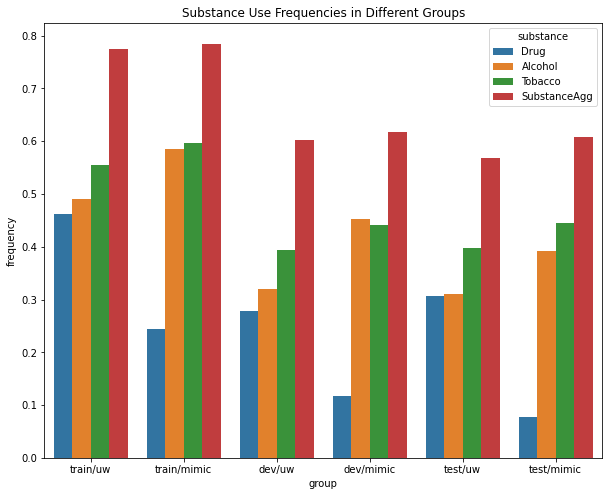

In [39]:
plt.figure(figsize=(10,8))
sns.barplot(x="group", y="frequency", data=df, hue='substance').set(title="Substance Use Frequencies in Different Groups")


In [58]:
base_dir = "/edata/xiruod/SocialDeterminants_SHAC_n2c2_2022/n2c2_sdoh_challenge"

tmp = {}
for c in itertools.product(['train','dev','test'], ['uw','mimic']):
    file_group = c[0] + "/" + c[1]
    
    df_labels = getPatientLabel(base_dir=base_dir, file_group=file_group)
    
    tmp[file_group] = [df_labels.shape[0]] + [df_labels['Drug'].sum()] + [df_labels['Alcohol'].sum()] + [df_labels['Tobacco'].sum()] + [df_labels['SubstanceAgg'].sum()]
    
    

In [60]:
tmp

{'train/uw': [1751, 809, 859, 973, 1355],
 'train/mimic': [1316, 320, 770, 786, 1033],
 'dev/uw': [259, 72, 83, 102, 156],
 'dev/mimic': [188, 22, 85, 83, 116],
 'test/uw': [518, 159, 161, 206, 294],
 'test/mimic': [373, 29, 146, 166, 227]}

In [74]:
ret = pd.DataFrame.from_dict(tmp, orient='columns').T
ret.columns = ['Total','Drug','Alcohol','Tobacco','SubstanceAggregation']

In [75]:
ret

,Total,Drug,Alcohol,Tobacco,SubstanceAggregation
train/uw,1751,809,859,973,1355
train/mimic,1316,320,770,786,1033
dev/uw,259,72,83,102,156
dev/mimic,188,22,85,83,116
test/uw,518,159,161,206,294
test/mimic,373,29,146,166,227
